<a href="https://colab.research.google.com/github/mahmud-nobe/Cluster-Membership/blob/master/NGC_2264/NGC_2264_version_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Necessary Packages and download the csv files

#### Importing packages

In [99]:
# import packages
import pandas as pd
import pandas_profiling as pd_prof
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# for downloading file
from google.colab import files

## Use random forest to create and evaluate new model
from sklearn.ensemble import RandomForestClassifier

In [100]:
!pip install astroquery

In [101]:
# import astroquery
import astropy.units as u
import astropy.coordinates as coord
from astroquery.gaia import Gaia
from astroquery.vizier import Vizier


#### Finding GAIA Data

In [102]:
## making a GAIA cone_search of 30m radius around NGC2264 center

coordinate = coord.SkyCoord.from_name('NGC2264')
print(coordinate)
radius = u.Quantity(1.1, u.deg)
Gaia.ROW_LIMIT = -1
j = Gaia.cone_search_async(coordinate, radius)
r = j.get_results()
print(type(r))

<SkyCoord (ICRS): (ra, dec) in deg
    (100.24166667, 9.895)>
INFO: Query finished. [astroquery.utils.tap.core]
<class 'astropy.table.table.Table'>


In [103]:
## save the ASCII table as a panadas dataframe
all_stars = r.to_pandas()
all_stars

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,...,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,dist
0,1635721458409799680,Gaia DR2 3326740861276259712,3326740861276259712,1365441235,2015.5,100.243956,0.279077,9.895051,0.338835,-6.363450,0.453980,-14.017026,-1.800098,0.465340,-6.549197,0.395891,-0.027930,-0.381382,-0.265434,0.435133,-0.707267,0.011102,-0.232205,0.354407,-0.090069,-0.305690,107,107,89,18,21.666466,791.063416,0.768447,73.128166,31,False,1.647182,1.958272,0.091477,-0.300088,...,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,202.936733,2.197765,100.365773,-13.176377,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,0.002250
1,1635721458409799680,Gaia DR2 3326740865570982400,3326740865570982400,911205744,2015.5,100.244416,0.523372,9.895739,0.496103,-0.784504,0.624335,-1.256544,-4.384980,0.991793,-6.574989,0.845571,-0.094483,0.201876,-0.028343,0.144926,-0.282828,0.020784,-0.170535,0.376963,0.019215,-0.000028,170,170,159,11,202.745163,101416.773438,2.757565,2478.627828,31,False,0.116784,1.690997,0.164906,-0.065167,...,8.760636e+07,398875.820038,219.633179,4.905581,1.017091,0,-0.378240,0.017767,-0.396007,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,202.936327,2.198482,100.366186,-13.175658,110101,9705.000000,8418.333008,9985.000000,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,0.002803
2,1635721458409799680,Gaia DR2 3326740865568919040,3326740865568919040,1396358324,2015.5,100.244941,0.598125,9.898119,0.510224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.211070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44,0,44,0,13.614263,322.398376,1.820949,30.112861,3,False,0.264112,1.641529,0.160584,-0.200346,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,202.934444,2.200029,100.366538,-13.173247,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,0.004486
3,1635721458409799680,Gaia DR2 3326741067438961664,3326741067438961664,1025584172,2015.5,100.241715,0.049001,9.899756,0.052610,1.286984,0.064376,19.991558,-1.463974,0.099293,-3.628493,0.089287,-0.083009,0.061895,-0.203724,0.138530,-0.572859,-0.000420,-0.285847,0.180690,0.150106,-0.020889,143,0,143,0,11.385525,425.318573,0.304088,12.811090,31,False,8.402239,1.500643,0.012230,-0.026078,...,3.227904e+04,1155.900454,27.925447,13.489618,1.411567,0,1.374199,0.503114,0.871085,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,202.931534,2.197949,100.363161,-13.171844,102001,4720.549805,4425.000000,5016.100098,NaN,NaN,NaN,NaN,NaN,NaN,200111,1.466251,1.298557,1.668657,0.961793,0.859278,1.064309,https://gea.esac.esa.int/data-server/datalink/...,,0.004763
4,1635721458409799680,Gaia DR2 3326740968649524480,33267409686

##### Applying Filter:

In [104]:
all_stars['pmra_over_error'] = abs(all_stars['pmra']/all_stars['pmra_error'])
all_stars['pmdec_over_error'] = abs(all_stars['pmdec']/all_stars['pmdec_error'])

In [105]:
all_stars_filtered = all_stars[all_stars['parallax_over_error'] > 3]

In [106]:
all_stars_filtered = all_stars_filtered[(all_stars_filtered.pmra_error < 0.3) & (all_stars_filtered.pmdec_error < 0.3)]

In [107]:
all_stars_filtered.shape

(19644, 99)

##### Visualizing GAIA data

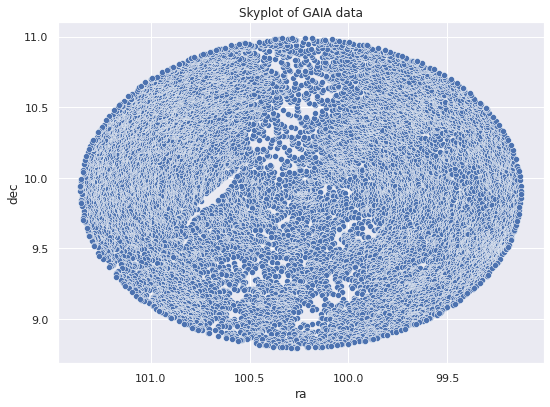

In [108]:
## plotting the skyplot 

sns.set(rc={'figure.figsize':(8.7,6.27)})

skyplot = sns.scatterplot(x='ra', y='dec', 
                          data = all_stars_filtered)
skyplot.invert_xaxis()
plt.title('Skyplot of GAIA data')
plt.show()

#### Finding Cantat Data

In [109]:
#### Finding Cantat catalogue

catalog_list = Vizier.find_catalogs('Cantat')
{k:v.description for k,v in catalog_list.items()}

{'I/349': 'StarHorse, Gaia DR2 photo-astrometric distances (Anders+, 2019)',
 'J/A+A/561/A94': 'Velocities and photometry in Trumpler 20 (Donati+, 2014)',
 'J/A+A/564/A133': 'Gaia FGK benchmark stars: metallicity (Jofre+, 2014)',
 'J/A+A/569/A17': 'Gaia-ESO Survey: NGC6705 (Cantat-Gaudin+, 2014)',
 'J/A+A/582/A81': 'Gaia FGK benchmark stars: abundances (Jofre+, 2015)',
 'J/A+A/588/A120': 'Equivalent widths in 10 open clusters (Cantat-Gaudin+, 2016)',
 'J/A+A/591/A37': 'Gaia-ESO Survey. Parameters for cluster members (Jacobson+, 2016)',
 'J/A+A/597/A10': 'South Ecliptic Pole stars radial velocities (Fremat+, 2017)',
 'J/A+A/598/A68': 'Gaia-ESO Survey. Trumpler 23 (Overbeek+, 2017)',
 'J/A+A/601/A19': 'Gaia DR1 open cluster members (Gaia Collaboration+, 2017)',
 'J/A+A/603/A2': 'Gaia-ESO Survey abundances radial distribution (Magrini+, 2017)',
 'J/A+A/605/A79': 'TGAS Cepheids and RR Lyrae stars (Gaia Collaboration+, 2017)',
 'J/A+A/615/A49': 'TGAS stars membership in 128 open clusters (C

In [110]:
## cheking the tables in the GAIA DR2 paper

Vizier.ROW_LIMIT = -1
#catalogs = Vizier.get_catalogs(catalog_list['J/A+A/633/A99'])
#catalogs

In [111]:
## saving only NGC 2264 data from Cantat GAIA DR2 paper

cantat_2264 = Vizier(catalog = 'J/A+A/633/A99/members', row_limit = -1).query_constraints(Cluster="NGC_2264")
cantat_2264 = cantat_2264[0].to_pandas()
cantat_2264

,RA_ICRS,DE_ICRS,Source,Plx,pmRA,pmDE,RV,Gmag,BP-RP,Proba,Cluster,_RA.icrs,_DE.icrs
0,100.288919,9.935567,3326741415326788480,1.3254,-1.851,-4.220,NaN,16.416100,3.1947,1.0,NGC_2264,100.288927,9.935585
1,100.268700,9.870169,3326739933563070720,1.3051,-0.975,-4.047,NaN,17.872499,2.0718,0.7,NGC_2264,100.268704,9.870186
2,100.321455,9.894364,3326740418894376704,1.2577,-1.297,-3.914,NaN,17.051701,2.4179,0.8,NGC_2264,100.321461,9.894381
3,100.293254,9.883825,3326740006577519360,1.1663,-1.773,-4.213,NaN,9.904700,-0.0007,0.8,NGC_2264,100.293262,9.883843
4,100.229922,9.847141,3326716397142282240,1.2713,-1.759,-2.658,NaN,15.305900,1.7208,0.1,NGC_2264,100.229930,9.847153
...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,100.139414,9.950729,3326929839837216640,1.1883,-1.923,-4.212,NaN,17.801300,2.6959,0.7,NGC_2264,100.139422,9.950747
182,100.240944,9.941617,3326929225657356288,1.3572,-1.452,-3.866,NaN,13.435300,1.1690,1.0,NGC_2264,100.240950,9.941634
183,100.190391,9.995125,3326930393888460288,1.5371,-1.218,-4.083,NaN,17.504801,2.3604,0.7,NGC_2264,100.190396,9.995143
184,100.223620,9.966662,3326929500535262464,1.4464,-1.454,-3.649,NaN,16.329500,2.0670,1.0,NGC_2264,100.223627,9.966677


In [112]:
# renaming the cantat table to match it with gaia_data
cantat_2264 = cantat_2264.rename(columns={'Source':'source_id',
                                          'Proba':'PMemb'})


In [113]:
# taking the subset of only source_id and PMemb
cantat_2264 = cantat_2264.loc[:,['source_id', 'PMemb']]


In [114]:
# join the two table on source_id
cantat_2264 = all_stars_filtered.join(cantat_2264.set_index('source_id'), on='source_id')

In [115]:
# dropping the rows, where we don't have PMemb 
# (i.e. the source id was not in the cantat table)
cantat_2264 = cantat_2264.dropna(subset=['PMemb'])
cantat_2264

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,...,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,dist,pmra_over_error,pmdec_over_error,PMemb
3,1635721458409799680,Gaia DR2 3326741067438961664,3326741067438961664,1025584172,2015.5,100.241715,0.049001,9.899756,0.052610,1.286984,0.064376,19.991558,-1.463974,0.099293,-3.628493,0.089287,-0.083009,0.061895,-0.203724,0.138530,-0.572859,-0.000420,-0.285847,0.180690,0.150106,-0.020889,143,0,143,0,11.385525,425.318573,0.304088,12.811090,31,False,8.402239,1.500643,0.012230,-0.026078,...,13.489618,1.411567,0,1.374199,0.503114,0.871085,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,202.931534,2.197949,100.363161,-13.171844,102001,4720.549805,4425.000000,5016.100098,NaN,NaN,NaN,NaN,NaN,NaN,200111,1.466251,1.298557,1.668657,0.961793,0.859278,1.064309,https://gea.esac.esa.int/data-server/datalink/...,,0.004763,14.744018,40.638442,1.0
5,1635721458409799680,Gaia DR2 3326740865570981632,3326740865570981632,1521413039,2015.5,100.245557,0.038982,9.900196,0.038836,1.362735,0.045918,29.677427,-1.137068,0.079773,-3.588939,0.074279,0.012196,-0.038531,-0.197566,0.162975,-0.433419,0.086858,-0.276304,0.140726,0.135813,-0.020499,159,159,156,3,12.263560,478.664429,0.067057,1.356665,31,True,110.686615,1.704489,0.010583,-0.030650,...,10.502198,1.172351,0,0.343633,0.126979,0.216654,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,202.932872,2.201518,100.367005,-13.171131,100001,7839.666504,7700.000000,8181.666504,0.600,0.1560,1.0341,0.3433,0.0770,0.5181,200111,2.492503,2.288481,2.583743,21.142500,20.141113,22.143887,https://gea.esac.esa.int/data-server/datalink/...,,0.006458,14.253728,48.316705,0.9
8,1635721458409799680,Gaia DR2 3326740964359745920,3326740964359745920,238254446,2015.5,100.232937,0.043918,9.898147,0.044957,1.248683,0.052859,23.623098,-1.432188,0.086068,-3.728367,0.076559,-0.064223,-0.099656,-0.225813,0.266703,-0.460557,0.141547,-0.359061,0.218600,0.111144,-0.075713,164,0,163,1,1.117678,177.989960,0.075689,0.373744,31,False,9.581892,1.381862,0.011180,-0.008528,...,14.794998,1.426720,0,1.878511,0.855293,1.023218,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,202.929017,2.189521,100.354423,-13.174077,100001,4027.333252,3858.000000,4257.020020,NaN,NaN,NaN,NaN,NaN,NaN,200111,1.247874,1.116849,1.359820,0.369068,0.334995,0.403141,https://gea.esac.esa.int/data-server/datalink/...,,0.009165,16.640103,48.699532,1.0
9,1635721458409799680,Gaia DR2 3326740861280539136,3326740861280539136,667918271,2015.5,100.248924,0.032822,9.901716,0.032414,1.332304,0.040609,32.807835,-2.016628,0.074140,-3.112353,0.080114,-0.017695,-0.143776,-0.059924,0.023423,-0.409806,0.074095,-0.174889,-0.038104,0.321486,-0.359434,143,0,143,0,0.018795,137.645889,0.000000,0.000000,31,False,20.898325,1.428460,0.008630,-0.085661,...,14.142661,1.401709,0,1.642935,0.698737,0.944198,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,202.933034,2.205162,100.370288,-13.169374,100001,4315.0

In [116]:
# saving both cantat and Gaia files as csv
# if you want to save, comment out the next two lines

cantat_2264.to_csv('NGC_2264_cantat.csv')
# all_stars.to_csv('NGC_2264_Gaia_30m.csv')

In [117]:
cantat_2264.describe()

,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,...,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,dist,pmra_over_error,pmdec_over_error,PMemb
count,1.790000e+02,1.790000e+02,1.790000e+02,179.0,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.0,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,...,1.740000e+02,174.000000,174.000000,174.000000,174.000000,179.000000,174.000000,174.000000,174.000000,3.000000,3.000000,179.000000,3.000000,3.000000,3.0,179.000000,179.000000,179.000000,179.000000,143.000000,143.000000,143.000000,143.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,128.0,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,179.000000,179.000000,179.000000,179.000000
mean,1.635721e+18,3.326785e+18,8.179047e+08,2015.5,100.214606,0.068841,9.878412,0.068337,1.353609,0.078069,22.170341,-1.702357,0.134283,-3.744136,0.119643,-0.128453,-0.011823,-0.234603,0.282137,-0.383949,0.180337,-0.362278,0.203304,0.089937,-0.103888,153.039106,17.597765,152.089385,0.949721,3.743837,259.469513,0.190569,3.486339,31.0,29.216709,1.404429,0.017565,-0.035321,17.430168,10.642458,...,1.281117e+05,354.689254,191.386612,14.465166,1.458958,0.134078,1.840550,0.853739,0.986811,17.663946,6.709235,0.106145,5833.333496,3.833333,0.0,202.938330,2.164443,100.337388,-13.195058,100560.524476,4534.251465,4247.730469,4906.962402,1.747458,1.442371,1.986919,0.877488,0.713944,1.003771,200111.0,1.408720,1.217725,1.548704,1.195102,1.119066,1.271138,0.080355,16.101421,39.682193,0.869274
std,0.000000e+00,8.903693e+13,5.036347e+08,0.0,0.060760,0.035174,0.062688,0.035382,0.095768,0.040253,10.771284,0.439287,0.067412,0.295697,0.060553,0.169292,0.138736,0.125775,0.134571,0.128509,0.130683,0.112218,0.113907,0.110772,0.184342,17.305699,48.216334,17.323519,1.503829,6.493741,316.778503,0.198130,9.287979,0.0,73.276215,0.133290,0.008888,0.078954,1.951486,0.675067,...,4.847058e+05,956.562667,187.253815,1.783463,0.204588,0.415852,0.679334,0.369787,0.345374,6.235787,4.756371,0.824428,288.675140,0.577350,0.0,0.057346,0.065031,0.060616,0.063483,900.873362,1418.274048,1241.912231,1467.577515,0.987902,0.909715,1.042373,0.494933,0.455351,0.527763,0.0,0.618332,0.618088,0.611171,3.740212,3.529193,3.951503,0.044847,8.739512,18.833557,0.203357
min,1.635721e+18,3.326712e+18,5.929410e+05,2015.5,100.057096,0.023724,9.751314,0.022577,1.111028,0.026016,6.770302,-3.389699,0.045983,-5.199818,0.041781,-0.960296,-0.685270,-0.885211,-0.377267,-0.702543,-0.271878,-0.933394,-0.694126,-0.667703,-0.896725,105.000000,0.000000,101.000000,0.000000,-6.49

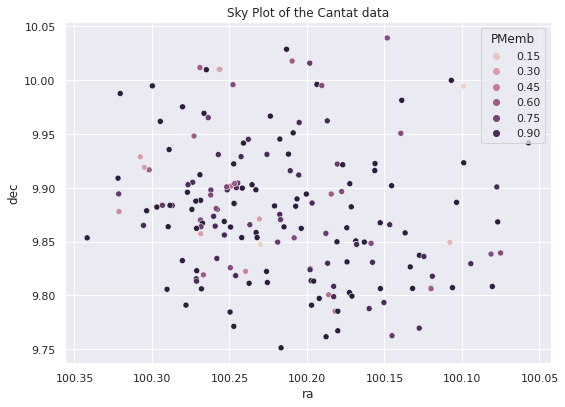

In [118]:
## plotting the skyplot 

skyplot = sns.scatterplot(x = cantat_2264['ra'], y = cantat_2264['dec'], 
                          hue = cantat_2264['PMemb'])
skyplot.invert_xaxis()
plt.title('Sky Plot of the Cantat data')
plt.show()

### Creating, Examining and Processing the Training Data


#### Training Data

In [119]:
# import member dataset
member = cantat_2264.copy()

In [120]:
### adding their distance from the center of the clusters

## NGC 2264
center = coord.SkyCoord.from_name('NGC2264')
center_ra, center_dec = center.ra.degree, center.dec.degree
distance = np.sqrt( ((member['ra'] - center_ra)*np.cos(np.radians(member['dec'])))**2 + (member['dec'] - center_dec)**2 )
member['dist_2264_center'] = distance

In [121]:
# maximum distance of stars in Cantat Data
cantat_radius = max(member.dist_2264_center)
cantat_radius

0.1877294773088183

In [122]:
member['member'] = np.full(len(member), 1)
member.head()

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,...,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,dist,pmra_over_error,pmdec_over_error,PMemb,dist_2264_center,member
3,1635721458409799680,Gaia DR2 3326741067438961664,3326741067438961664,1025584172,2015.5,100.241715,0.049001,9.899756,0.052610,1.286984,0.064376,19.991558,-1.463974,0.099293,-3.628493,0.089287,-0.083009,0.061895,-0.203724,0.138530,-0.572859,-0.000420,-0.285847,0.180690,0.150106,-0.020889,143,0,143,0,11.385525,425.318573,0.304088,12.811090,31,False,8.402239,1.500643,0.012230,-0.026078,...,0,1.374199,0.503114,0.871085,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,202.931534,2.197949,100.363161,-13.171844,102001,4720.549805,4425.000000,5016.100098,NaN,NaN,NaN,NaN,NaN,NaN,200111,1.466251,1.298557,1.668657,0.961793,0.859278,1.064309,https://gea.esac.esa.int/data-server/datalink/...,,0.004763,14.744018,40.638442,1.0,0.004757,1
5,1635721458409799680,Gaia DR2 3326740865570981632,3326740865570981632,1521413039,2015.5,100.245557,0.038982,9.900196,0.038836,1.362735,0.045918,29.677427,-1.137068,0.079773,-3.588939,0.074279,0.012196,-0.038531,-0.197566,0.162975,-0.433419,0.086858,-0.276304,0.140726,0.135813,-0.020499,159,159,156,3,12.263560,478.664429,0.067057,1.356665,31,True,110.686615,1.704489,0.010583,-0.030650,...,0,0.343633,0.126979,0.216654,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,202.932872,2.201518,100.367005,-13.171131,100001,7839.666504,7700.000000,8181.666504,0.6,0.156,1.0341,0.3433,0.077,0.5181,200111,2.492503,2.288481,2.583743,21.142500,20.141113,22.143887,https://gea.esac.esa.int/data-server/datalink/...,,0.006458,14.253728,48.316705,0.9,0.006457,1
8,1635721458409799680,Gaia DR2 3326740964359745920,3326740964359745920,238254446,2015.5,100.232937,0.043918,9.898147,0.044957,1.248683,0.052859,23.623098,-1.432188,0.086068,-3.728367,0.076559,-0.064223,-0.099656,-0.225813,0.266703,-0.460557,0.141547,-0.359061,0.218600,0.111144,-0.075713,164,0,163,1,1.117678,177.989960,0.075689,0.373744,31,False,9.581892,1.381862,0.011180,-0.008528,...,0,1.878511,0.855293,1.023218,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,202.929017,2.189521,100.354423,-13.174077,100001,4027.333252,3858.000000,4257.020020,NaN,NaN,NaN,NaN,NaN,NaN,200111,1.247874,1.116849,1.359820,0.369068,0.334995,0.403141,https://gea.esac.esa.int/data-server/datalink/...,,0.009165,16.640103,48.699532,1.0,0.009157,1
9,1635721458409799680,Gaia DR2 3326740861280539136,3326740861280539136,667918271,2015.5,100.248924,0.032822,9.901716,0.032414,1.332304,0.040609,32.807835,-2.016628,0.074140,-3.112353,0.080114,-0.017695,-0.143776,-0.059924,0.023423,-0.409806,0.074095,-0.174889,-0.038104,0.321486,-0.359434,143,0,143,0,0.018795,137.645889,0.000000,0.000000,31,False,20.898325,1.428460,0.008630,-0.085661,...,0,1.642935,0.698737,0.944198,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,202.933034,2.205162,100.370288,-13.169374,100001,4315.000000,4194.449707,4420.750000,NaN,NaN,NaN,NaN,NaN,NaN,200111,1.31

In [123]:
### adding their distance from the center of the clusters

## NGC 2264
center = coord.SkyCoord.from_name('NGC2264')
center_ra, center_dec = center.ra.degree, center.dec.degree
distance = np.sqrt( ((all_stars_filtered['ra'] - center_ra)*np.cos(np.radians(all_stars_filtered['dec'])))**2 + (all_stars_filtered['dec'] - center_dec)**2 )
all_stars_filtered['dist_2264_center'] = distance

In [124]:
non_member = all_stars_filtered[all_stars_filtered['dist_2264_center'] >= 1].sample(len(member), random_state = 42)

In [125]:
non_member['member'] = np.full(len(non_member), 0)
non_member.head()

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,...,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,dist,pmra_over_error,pmdec_over_error,dist_2264_center,member
108087,1635721458409799680,Gaia DR2 3326506012463930752,3326506012463930752,1007833897,2015.5,99.843058,0.077361,8.939018,0.084965,3.196830,0.105026,30.438431,-12.600089,0.151483,-13.086975,0.141750,-0.049237,0.027650,-0.071642,0.230546,-0.556732,0.070083,-0.234773,0.213800,0.193228,-0.115133,137,0,136,1,2.321526,171.485672,0.307615,2.859861e+00,31,False,3.058971,1.313341,0.023269,-0.025431,...,1.427695,0,2.221597,1.126602,1.094995,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,203.606505,1.408925,100.030033,-14.158205,100001,4085.327637,3540.000000,5102.310059,0.0353,0.0140,0.1060,0.0240,0.0076,0.0580,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,,1.033696,83.178139,92.324360,1.033902,0
102951,1635721458409799680,Gaia DR2 3134465109696011392,3134465109696011392,951982756,2015.5,100.949550,0.043878,9.160776,0.042618,1.414852,0.051494,27.476072,6.123362,0.089279,-9.456757,0.084317,-0.179994,0.129054,0.032203,0.211109,-0.421771,0.120956,-0.151793,0.131080,0.154207,-0.215223,142,0,141,1,-1.247537,115.845116,0.000000,0.000000e+00,31,False,10.653710,1.517296,0.010823,-0.113548,...,1.249153,0,1.253318,0.555948,0.697370,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,203.908311,2.482343,101.136244,-13.856217,100001,4898.814941,4795.594727,5015.625000,0.1760,0.0160,0.3430,0.0615,0.0079,0.1561,200111,0.632506,0.603388,0.660027,0.207581,0.191050,0.224113,https://gea.esac.esa.int/data-server/datalink/...,,1.013128,68.586888,112.156688,1.013648,0
115269,1635721458409799680,Gaia DR2 3326555902802332672,3326555902802332672,745107822,2015.5,99.629150,0.035430,9.022300,0.034174,1.885726,0.042319,44.559578,-6.698172,0.065830,5.503533,0.056485,-0.158210,0.216892,-0.292523,0.178727,-0.452152,-0.041419,-0.469140,0.345417,0.216866,0.000107,159,114,158,1,4.683323,249.492249,0.000000,0.000000e+00,31,False,191.830170,1.624119,0.009568,-0.033074,...,1.196600,0,0.708639,0.281944,0.426695,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,203.435641,1.259262,99.806728,-14.089780,100001,6436.903809,6151.000000,7046.839844,0.0605,0.0367,0.0870,0.0287,0.0154,0.0431,200111,1.009914,0.842655,1.105979,1.577507,1.521386,1.633629,https://gea.esac.esa.int/data-server/datalink/...,,1.061433,101.749443,97.433698,1.061864,0
100399,1635721458409799680,Gaia DR2 3326524914616093824,3326524914616093824,1261800563,2015.5,100.052238,0.035016,8.909980,0.030491,0.664244,0.043244,15.360253,-2.020080,0.057033,-2.288863,0.051291,-0.326818,0.543335,0.014437,0.227931,-0.502746,0.028265,-0.222523,0.251802,0.126502,-0.000261,124,0,122,2,-2.636672,80.602707,0.000000,9.289926e-16,31,True,51.321205,1.631058,0.006945,-0.054402,...,1.208052,0,0.800797,0.321181,0.479615,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,203.726933,1.579375,100.244747,-14.172525,1

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


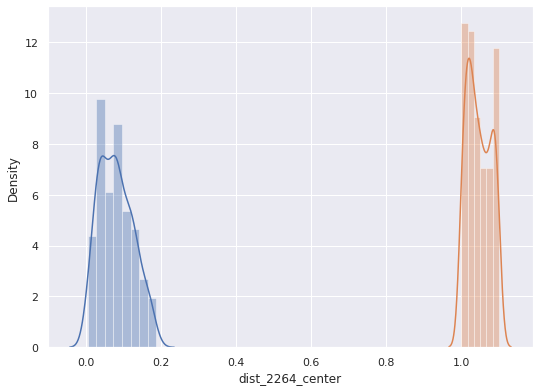

In [126]:
sns.distplot(member['dist_2264_center'])
sns.distplot(non_member['dist_2264_center'])
plt.show()

In [127]:
training_data = pd.concat([member, non_member])

In [128]:
# Examining the descriptive statistics of each column
training_data.describe()

,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,...,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,dist,pmra_over_error,pmdec_over_error,PMemb,dist_2264_center,member
count,3.580000e+02,3.580000e+02,3.580000e+02,358.0,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.0,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,...,351.000000,351.000000,351.000000,358.000000,351.000000,351.000000,351.000000,13.000000,13.000000,358.000000,13.000000,13.000000,13.000000,358.000000,358.000000,358.000000,358.000000,280.000000,280.000000,280.000000,280.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,206.0,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,358.000000,358.000000,358.000000,179.000000,358.000000,358.0000
mean,1.635721e+18,3.320252e+18,8.204605e+08,2015.5,100.209532,0.067936,9.882191,0.067562,1.208413,0.079212,19.939291,-1.357391,0.132243,-3.696092,0.117643,-0.147467,0.037117,-0.201951,0.265821,-0.388781,0.148487,-0.341902,0.225388,0.111230,-0.118648,147.715084,13.770950,146.818436,0.896648,2.448332,213.075470,0.143327,2.375564,31.0,32.915611,1.445441,0.017323,-0.045567,16.840782,10.592179,...,285.845673,14.721298,1.381668,0.106145,1.647219,0.759988,0.887231,32.903968,2.859479,0.156425,5384.615234,3.423077,-0.115385,202.932220,2.161821,100.331737,-13.190467,100329.642857,4653.865234,4420.915039,4978.721191,1.262958,1.006472,1.518066,0.631597,0.496413,0.767128,200111.0,1.965957,1.726620,2.142162,3.636091,3.141177,4.131003,0.563746,28.630887,50.054559,0.869274,0.563739,0.5000
std,0.000000e+00,4.685139e+16,4.945317e+08,0.0,0.592513,0.034028,0.461118,0.034937,1.177568,0.041820,23.883413,7.913965,0.065837,7.963822,0.059025,0.162205,0.159219,0.146039,0.125350,0.143033,0.145697,0.117397,0.109406,0.105302,0.170222,17.605141,42.717534,17.495513,1.331767,5.439698,241.385040,0.185172,7.511951,0.0,79.093056,0.119368,0.008684,0.079539,1.960338,0.649193,...,243.051910,1.712105,0.174277,0.366551,0.615803,0.340256,0.299653,23.025235,3.248466,0.852152,617.584229,0.534094,0.416025,0.468744,0.577871,0.595724,0.465726,742.393456,1169.028564,1066.091675,1196.526489,0.903079,0.827793,0.939899,0.452254,0.414632,0.477566,0.0,2.579946,2.297373,2.793334,10.690964,9.077734,12.351361,0.485591,103.562415,115.582553,0.203357,0.485586,0.5007
min,1.635721e+18,3.134360e+18,5.929410e+05,2015.5,99.125155,0.020532,8.803543,0.018646,0.167861,0.022120,3.012790,-128.078219,0.039267,-83.102206,0.034156,-0.960296,-0.685270,-0.885211,-0.377267,-0.815546,-0.347399,-0.933394,-0.694126,-0.667703,-0.896725,97.000000,0.000000,96.000000,0.000000,-6.497139,5

In [129]:
# Choosing the features

feature_columns = ['parallax',
                   'pmra', 'pmdec']

features = training_data.loc[:,feature_columns]
targets = training_data['member']

In [130]:
# Dropping the NULL values from the using training set
# adding features and targets in a training set
training_set = pd.concat((features, targets), axis=1)

# dropping NA
training_set = training_set.dropna()

# finding where dtype is float64
float64_data = np.where(training_set.dtypes == 'float64')[0] 

# change the data type to float32 from float64
training_set.iloc[:, float64_data] = training_set.iloc[:, float64_data].astype('float32')


# set features, targets again
features, targets = training_set.iloc[:,:-1], training_set.iloc[:,-1]

features.describe()

,parallax,pmra,pmdec
count,358.000000,358.000000,358.000000
mean,1.208413,-1.357391,-3.696092
std,1.177569,7.913965,7.963821
min,0.167861,-128.078217,-83.102203
25%,0.557985,-1.782382,-3.963914
50%,1.283905,-1.423649,-3.620222
75%,1.393622,0.040845,-2.105748
max,12.818313,28.319778,67.285141


In [131]:
targets.value_counts()

1    179
0    179
Name: member, dtype: int64

#### Visualizing Training Data


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


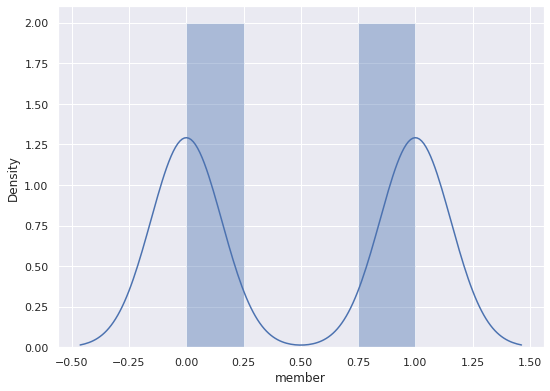

In [132]:
# histogram of PMemb in the training data
sns.distplot(training_set['member'])
plt.show()

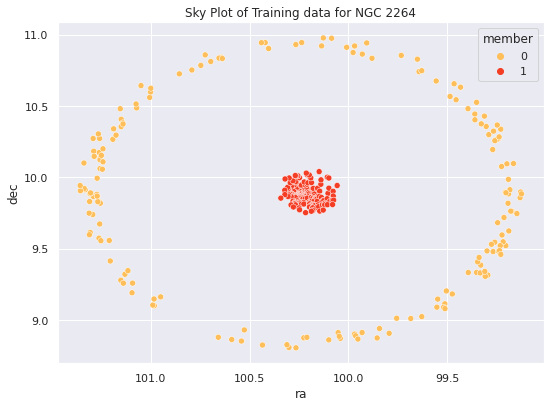

In [133]:
sns.set(rc={'figure.figsize':(8.7,6.27)})

skyplot = sns.scatterplot(x = 'ra', y='dec', palette='YlOrRd', hue = 'member', data = training_data)
skyplot.invert_xaxis()
plt.title('Sky Plot of Training data for NGC 2264')
plt.show()

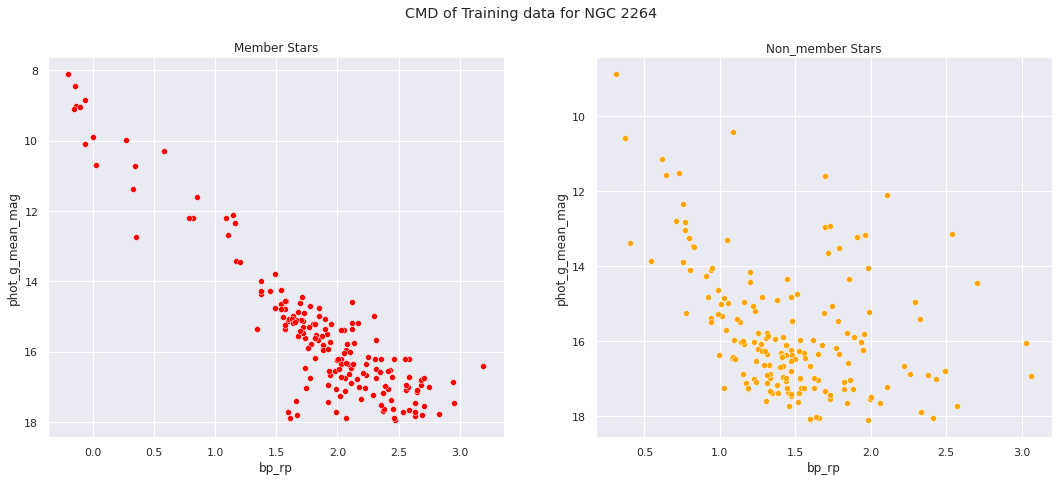

In [134]:
# CMD marked with the membership probabilities of the stars 
# (PMemb >= 0.5 stars are the probable stars)
#cmd = sns.scatterplot(x = 'bp_rp', y='phot_g_mean_mag', palette='YlOrRd', hue = 'PMemb', data = training_data)
#cmd.invert_yaxis()
#plt.title('')
#plt.show()

# proper motion plot marked with the membership probabilities of the stars 

fig, axes = plt.subplots(1, 2, figsize=(18,7))
fig.suptitle('CMD of Training data for NGC 2264 ')

sns.scatterplot(x = 'bp_rp', y='phot_g_mean_mag', palette='YlOrRd', color = 'red',
                data = member, ax = axes[0])
axes[0].set_title('Member Stars')
axes[0].invert_yaxis()

#plt.show()
sns.scatterplot(x = 'bp_rp', y='phot_g_mean_mag', palette='YlOrRd', color = 'orange',
                data = non_member, ax = axes[1])
axes[1].set_title('Non_member Stars')
axes[1].invert_yaxis()

plt.show()


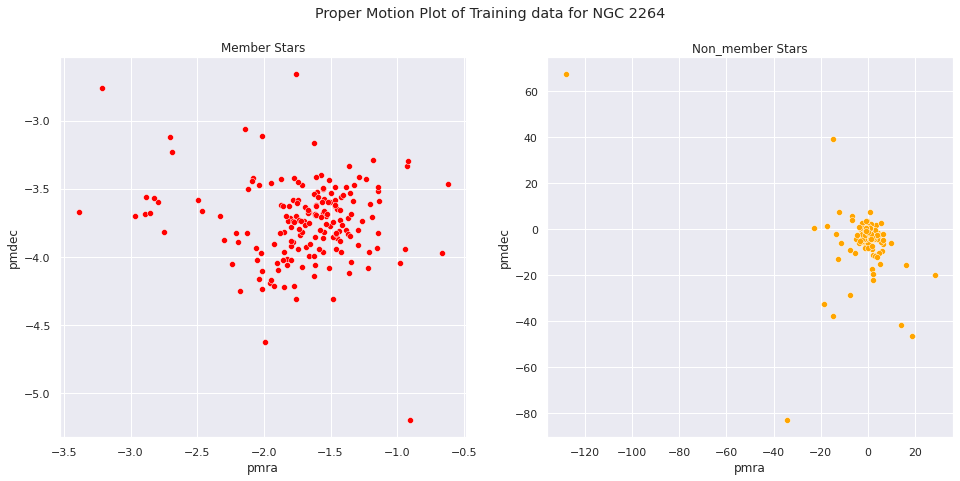

In [135]:
# proper motion plot marked with the membership probabilities of the stars 

fig, axes = plt.subplots(1, 2, figsize=(16,7))
fig.suptitle('Proper Motion Plot of Training data for NGC 2264 ')

sns.scatterplot(x = 'pmra', y='pmdec', palette='YlOrRd', color = 'red',
                data = member, ax = axes[0])
axes[0].set_title('Member Stars')
#plt.show()
sns.scatterplot(x = 'pmra', y='pmdec', palette='YlOrRd', color = 'orange',
                data = non_member, ax = axes[1])
axes[1].set_title('Non_member Stars')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


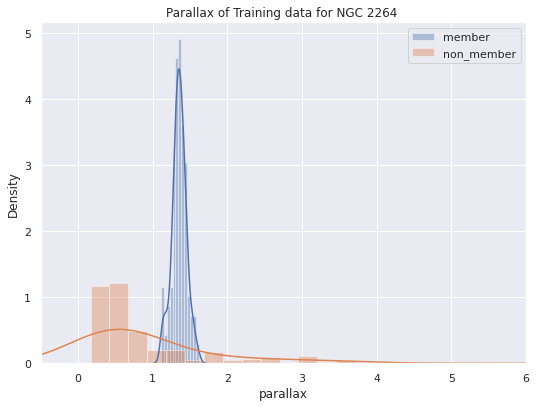

In [136]:
sns.distplot(member.parallax, label='member')
sns.distplot(non_member.parallax, label = 'non_member')
plt.xlim(-0.5,6)
plt.title('Parallax of Training data for NGC 2264 ')
plt.legend()
plt.show()

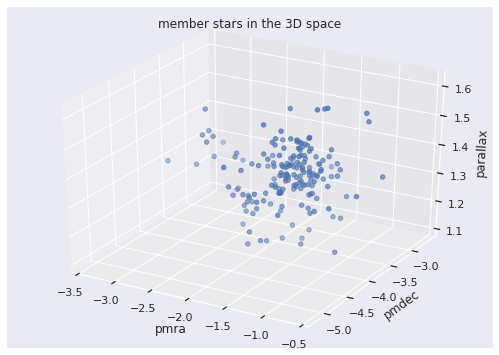

In [137]:
from mpl_toolkits.mplot3d import Axes3D


ax = plt.figure().gca(projection='3d')

ax.scatter(member.pmra, member.pmdec, member.parallax)
ax.set_xlabel('pmra')
ax.set_ylabel('pmdec')
ax.set_zlabel('parallax')
plt.title('member stars in the 3D space')
plt.show()


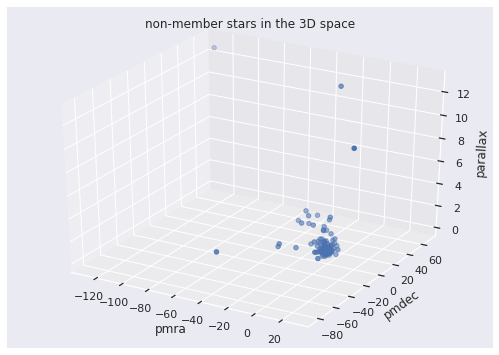

In [138]:
ax = plt.figure().gca(projection='3d')

ax.scatter(non_member.pmra, non_member.pmdec, non_member.parallax)
ax.set_xlabel('pmra')
ax.set_ylabel('pmdec')
ax.set_zlabel('parallax')
plt.title('non-member stars in the 3D space')
plt.show()


#### Check Feature Importance using Random Forest

In [139]:
# Use Random Forest on whole dataset using 100 different trees 
rfc = RandomForestClassifier(n_estimators = 100, oob_score = True)
rfc.fit(features, targets)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [140]:
# checking the feature importance, 
# ( this is higher for a variable if the model efficiency become lower as we remove that variable)
feature_imp = pd.Series(rfc.feature_importances_, index=features.columns).sort_values(ascending = False)
feature_imp

parallax    0.394946
pmra        0.314600
pmdec       0.290455
dtype: float64

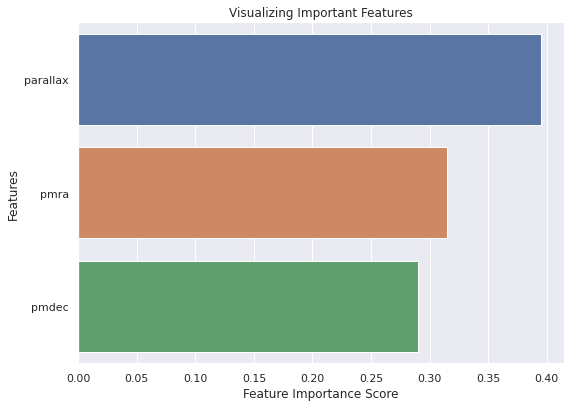

In [141]:
# plotting as a barplot

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

### Model Selection and Accuracy Estimate using Test Data

In [142]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, classification_report

In [143]:
from sklearn.model_selection import train_test_split
# splitting our dataset using 0.3 test ratio (30% test data, 70% train data)
train_features, test_features, train_targets, test_targets = train_test_split(features, 
                                                                                targets, 
                                                                                test_size = 0.3, 
                                                                                random_state=258)

In [144]:
def evaluate_model(model):
    test_predict = model.predict(test_features)
    train_predict = model.predict(train_features)

    print('Model Accuracy:')
    print("Precision on training data: %.3f" % precision_score(train_targets, train_predict))
    print("Precision on testing data: %.3f" % precision_score(test_targets, test_predict))
    print('Accuracy on test data: %.3f' % accuracy_score(test_targets, test_predict))


    sns.heatmap(confusion_matrix(test_targets, test_predict), cmap= 'Greens', annot = True)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

    print("Classification Report: \n", classification_report(test_targets, test_predict))

#### Random Forest

In [145]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['auto', 'sqrt']
# Maximum number of levels
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
ccp_alpha = [2**i for i in range(-10,0)]+[0]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'ccp_alpha': ccp_alpha}

random_grid

{'bootstrap': [True, False],
 'ccp_alpha': [0.0009765625,
  0.001953125,
  0.00390625,
  0.0078125,
  0.015625,
  0.03125,
  0.0625,
  0.125,
  0.25,
  0.5,
  0],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}

In [146]:
rfc = RandomForestClassifier(random_state = 42,
                                    oob_score = True)

rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, 
                               n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1,
                               scoring = 'precision')

In [147]:
rfc_random.fit(train_features, train_targets)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 170 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 373 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.0min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [148]:
rfc_random.best_params_


{'bootstrap': True,
 'ccp_alpha': 0.0009765625,
 'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 100}

Model Accuracy:
Precision on training data: 1.000
Precision on testing data: 1.000
Accuracy on test data: 0.991


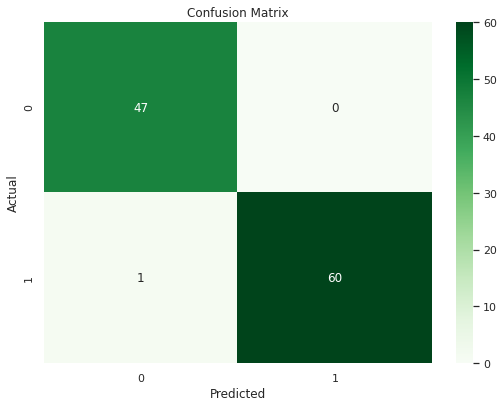

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        47
           1       1.00      0.98      0.99        61

    accuracy                           0.99       108
   macro avg       0.99      0.99      0.99       108
weighted avg       0.99      0.99      0.99       108



In [149]:
base_model = RandomForestClassifier(n_estimators = 100, random_state = 42,
                                    oob_score = True)
base_model.fit(train_features, train_targets)

evaluate_model(base_model)


Model Accuracy:
Precision on training data: 1.000
Precision on testing data: 1.000
Accuracy on test data: 0.991


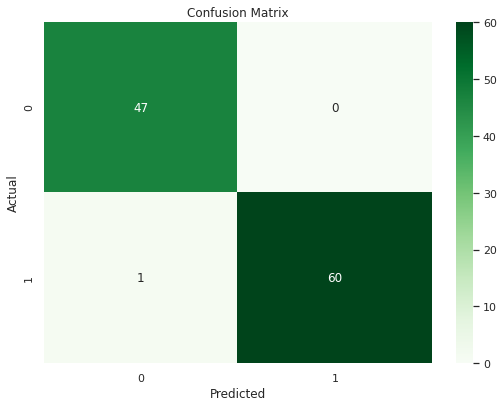

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        47
           1       1.00      0.98      0.99        61

    accuracy                           0.99       108
   macro avg       0.99      0.99      0.99       108
weighted avg       0.99      0.99      0.99       108



In [150]:
best_random = rfc_random.best_estimator_

evaluate_model(best_random)


### Prediction for the new stars

In [151]:
# descriptive stats
all_stars_filtered.describe()

,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,...,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,dist,pmra_over_error,pmdec_over_error,dist_2264_center
count,1.964400e+04,1.964400e+04,1.964400e+04,19644.0,19644.000000,19644.000000,19644.000000,19644.000000,19644.000000,19644.000000,19644.000000,19644.000000,19644.000000,19644.000000,19644.000000,19644.000000,19644.000000,19644.000000,19644.000000,19644.000000,19644.000000,19644.000000,19644.000000,19644.000000,19644.000000,19644.000000,19644.000000,19644.000000,19644.000000,19644.000000,19644.000000,19644.000000,19644.000000,19644.0,19644.000000,19644.000000,19644.000000,19644.000000,19644.000000,19644.000000,...,1.953300e+04,19533.000000,19533.000000,19533.000000,19533.000000,19644.000000,19533.000000,19533.000000,19533.000000,580.000000,580.000000,19644.000000,580.000000,580.000000,580.000000,19644.000000,19644.000000,19644.000000,19644.000000,14692.000000,14692.000000,14692.000000,14692.000000,7224.000000,7224.000000,7224.000000,7224.000000,7224.000000,7224.000000,8737.0,8737.000000,8737.000000,8737.000000,8737.000000,8737.000000,8737.000000,19644.000000,19644.000000,19644.000000,19644.000000
mean,1.635721e+18,3.324525e+18,8.501517e+08,2015.5,100.254592,0.070690,9.925864,0.070101,0.842245,0.082911,13.328013,-0.208044,0.137368,-3.156554,0.121899,-0.191801,0.070969,-0.180597,0.254791,-0.386841,0.124309,-0.324819,0.240280,0.114622,-0.150696,138.893657,6.327734,138.162441,0.731216,0.874058,160.064835,0.085385,1.214642,31.0,25.174942,1.479335,0.017891,-0.063681,15.851049,10.394013,...,3.952744e+04,109.977847,354.307281,15.144622,1.314656,0.058033,1.493290,0.684752,0.808539,27.544786,2.299559,0.130523,5345.862305,3.522414,-0.103017,202.913552,2.221257,100.373956,-13.143549,100041.702831,4733.982910,4556.795410,5018.958984,1.126676,0.892509,1.404187,0.561388,0.441407,0.702552,200111.0,2.475880,2.214180,2.666309,6.512360,5.446680,7.578040,0.774922,22.364592,42.062593,0.774894
std,0.000000e+00,4.482330e+16,4.917040e+08,0.0,0.624755,0.033458,0.530853,0.033761,0.921778,0.040904,18.301750,5.404338,0.064898,7.320908,0.058322,0.167678,0.172139,0.170596,0.147583,0.163631,0.178528,0.146400,0.112048,0.111206,0.168029,18.839033,28.309065,18.761357,1.127264,3.863940,154.835632,0.146951,6.333248,0.0,62.254005,0.085724,0.008751,0.088851,2.063274,0.718988,...,3.734137e+05,1419.377041,259.219513,1.427080,0.096525,0.254256,0.468916,0.282319,0.197977,32.236548,2.816651,0.800821,698.376099,0.623668,0.376403,0.531730,0.614990,0.628612,0.534621,282.079164,741.979431,721.112732,757.616150,0.773925,0.729224,0.826140,0.389881,0.365010,0.419528,0.0,4.048553,3.651737,4.369830,33.385719,28.253939,38.682877,0.247259,50.586481,87.950007,0.247252
min,1.635721e+18,3.134355e+18,1.387950e+05,2015.5,99.125155,0.018401,8.796217,0.017402,0.098687,0.020416,3.000147,-128.078219

In [152]:
# chosing only GAIA stars close to 0.40 degree radius of the center
all_stars_filtered = all_stars_filtered.dropna(subset = feature_columns)
GAIA_target_stars = all_stars_filtered[all_stars_filtered['dist_2264_center'] <= 0.60]

In [153]:
# removing the member stars from GAIA data
GAIA_target_stars = pd.concat([GAIA_target_stars, training_data.drop(columns=['PMemb', 'member']), 
                               training_data.drop(columns=['PMemb', 'member'])]).drop_duplicates(keep=False)

In [154]:
# select the set of predictor variables from the new dataset
new_features = GAIA_target_stars.loc[:, feature_columns]
new_features = new_features.astype('float32')

In [155]:
# train the model again using all the features and targets of the previous dataset
# rfc.fit(features, targets)

In [156]:
# estimate the membership classification of the stars
GAIA_target_stars['member'] = best_random.predict(new_features)
GAIA_target_stars['member'].value_counts()

0    3979
1     514
Name: member, dtype: int64

In [157]:
# estimate the membership probability of the stars
GAIA_target_stars['PMemb'] = best_random.predict_proba(new_features)[:,1]
sum(GAIA_target_stars['PMemb'] >= 0.5)

514

In [158]:
potentialMember = GAIA_target_stars[GAIA_target_stars['member'] == 1]
len(potentialMember)

514

In [159]:
potentialMember.describe()

,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,...,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,dist,pmra_over_error,pmdec_over_error,dist_2264_center,member,PMemb
count,5.140000e+02,5.140000e+02,5.140000e+02,514.0,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.0,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,...,511.000000,511.000000,511.000000,514.000000,511.000000,511.000000,511.000000,5.000000,5.000000,514.000000,5.0,5.000000,5.0,514.000000,514.000000,514.000000,514.000000,362.000000,362.000000,362.000000,362.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,334.0,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,514.000000,514.000000,514.000000,514.000000,514.0,514.000000
mean,1.635721e+18,3.327268e+18,8.436785e+08,2015.5,100.213664,0.078407,9.719598,0.076216,1.349664,0.089473,19.844873,-2.032736,0.151625,-3.712294,0.131401,-0.139760,0.022291,-0.230909,0.257528,-0.349447,0.139489,-0.360802,0.262352,0.103417,-0.112707,139.402724,10.060311,138.647860,0.754864,3.085883,212.086456,0.206329,2.954514,31.0,24.681902,1.390036,0.020854,-0.035328,15.980545,10.377432,...,182.367493,14.830009,1.449586,0.052529,2.013970,0.992499,1.021470,14.909499,6.266706,0.048638,6250.0,3.900000,0.0,203.079248,2.091114,100.348313,-13.353397,100244.447514,4463.657715,4197.500977,4869.649902,1.746421,1.464235,1.998381,0.880061,0.733061,1.009456,200111.0,1.370198,1.161931,1.510555,1.236500,1.154160,1.318840,0.358158,17.101597,36.366140,0.358170,1.0,0.919342
std,0.000000e+00,3.503582e+15,4.908713e+08,0.0,0.197042,0.036165,0.271371,0.035225,0.125025,0.042569,11.710696,0.546059,0.069538,0.361765,0.060490,0.169178,0.154679,0.165271,0.138835,0.142805,0.158510,0.134591,0.097201,0.102134,0.163252,18.840959,36.188836,18.628368,1.265152,5.024782,198.426010,0.193361,7.902415,0.0,61.721043,0.123716,0.009665,0.093176,2.082979,0.734526,...,211.294388,1.615815,0.207246,0.240134,0.689168,0.411808,0.313344,10.930656,4.513579,0.510674,500.0,0.547723,0.0,0.265642,0.202187,0.201975,0.269657,654.411358,1310.601807,1192.303955,1325.722290,0.990322,0.945375,1.013360,0.503232,0.477584,0.520931,0.0,0.601475,0.575156,0.605666,6.684926,6.320576,7.049437,0.119950,10.486763,20.217967,0.119951,0.0,0.124743
min,1.635721e+18,3.326589e+18,1.328751e+07,2015.5,99.637923,0.020872,9.304602,0.019971,1.082534,0.021649,5.836907,-4.065149,0.039281,-4.840374,0.035394,-0.831352,-0.668835,-0.872752,-0.634873,-0.876462,-0.676993,-0.896394,-0.189241,-0.646195,-0.831819,86.000000,0.000000,85.000000,0.000000,-6.599565,48.506165,0.000000,0.000000,31.0,0.725791,1.193693,0.

In [160]:
member.describe()

,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,...,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,dist,pmra_over_error,pmdec_over_error,PMemb,dist_2264_center,member
count,1.790000e+02,1.790000e+02,1.790000e+02,179.0,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.0,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,...,174.000000,174.000000,174.000000,179.000000,174.000000,174.000000,174.000000,3.000000,3.000000,179.000000,3.000000,3.000000,3.0,179.000000,179.000000,179.000000,179.000000,143.000000,143.000000,143.000000,143.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,128.0,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.0
mean,1.635721e+18,3.326785e+18,8.179047e+08,2015.5,100.214606,0.068841,9.878412,0.068337,1.353609,0.078069,22.170341,-1.702357,0.134283,-3.744136,0.119643,-0.128453,-0.011823,-0.234603,0.282137,-0.383949,0.180337,-0.362278,0.203304,0.089937,-0.103888,153.039106,17.597765,152.089385,0.949721,3.743837,259.469513,0.190569,3.486339,31.0,29.216709,1.404429,0.017565,-0.035321,17.430168,10.642458,...,191.386612,14.465166,1.458958,0.134078,1.840550,0.853739,0.986811,17.663946,6.709235,0.106145,5833.333496,3.833333,0.0,202.938330,2.164443,100.337388,-13.195058,100560.524476,4534.251465,4247.730469,4906.962402,1.747458,1.442371,1.986919,0.877488,0.713944,1.003771,200111.0,1.408720,1.217725,1.548704,1.195102,1.119066,1.271138,0.080355,16.101421,39.682193,0.869274,0.080356,1.0
std,0.000000e+00,8.903693e+13,5.036347e+08,0.0,0.060760,0.035174,0.062688,0.035382,0.095768,0.040253,10.771284,0.439287,0.067412,0.295697,0.060553,0.169292,0.138736,0.125775,0.134571,0.128509,0.130683,0.112218,0.113907,0.110772,0.184342,17.305699,48.216334,17.323519,1.503829,6.493741,316.778503,0.198130,9.287979,0.0,73.276215,0.133290,0.008888,0.078954,1.951486,0.675067,...,187.253815,1.783463,0.204588,0.415852,0.679334,0.369787,0.345374,6.235787,4.756371,0.824428,288.675140,0.577350,0.0,0.057346,0.065031,0.060616,0.063483,900.873362,1418.274048,1241.912231,1467.577515,0.987902,0.909715,1.042373,0.494933,0.455351,0.527763,0.0,0.618332,0.618088,0.611171,3.740212,3.529193,3.951503,0.044847,8.739512,18.833557,0.203357,0.044847,0.0
min,1.635721e+18,3.326712e+18,5.929410e+05,2015.5,100.057096,0.023724,9.751314,0.022577,1.111028,0.026016,6.770302,-3.389699,0.045983,-5.199818,0.041781,-0.960296,-0.685270,-0.885211,-0.377267,-0.702543,-0.271878,-0.933394,-0.694126,-0.667703,-0.896725,105.000000,0.000000,101.000000,0.000000,-6.497139,53.549519,0.000000,0.000000,31.0,0.800282,

#### Visualization

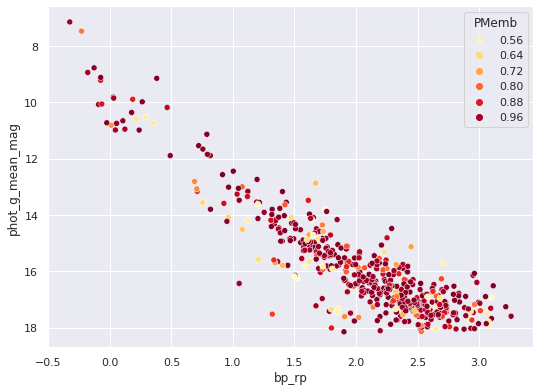

In [161]:
# CMD of predicted members 

cmd = sns.scatterplot(x = 'bp_rp', y = 'phot_g_mean_mag', hue= 'PMemb', 
                      palette='YlOrRd', data = GAIA_target_stars[GAIA_target_stars['PMemb'] >= 0.5] )
cmd.invert_yaxis()

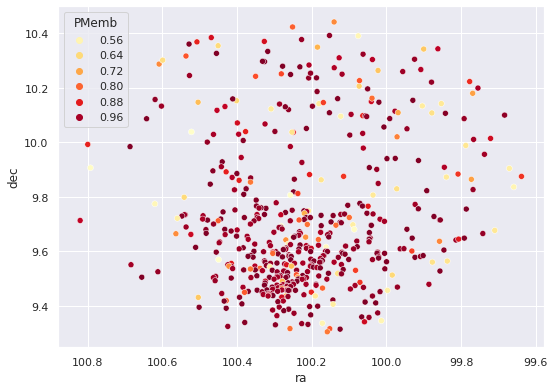

In [162]:
skyplot = sns.scatterplot(x = 'ra', y = 'dec', hue= 'PMemb', 
                      palette='YlOrRd', data = GAIA_target_stars[GAIA_target_stars['PMemb'] >= 0.5] )
skyplot.invert_xaxis()

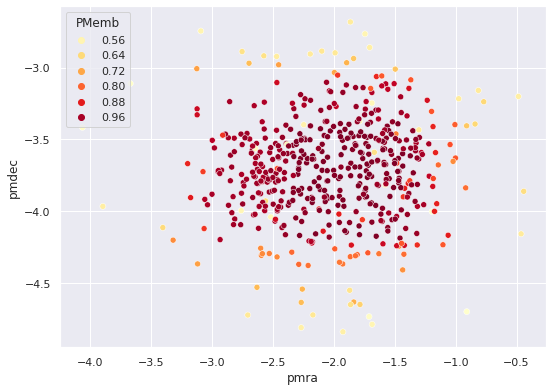

In [163]:
# pm plot
sns.scatterplot(x = 'pmra', y = 'pmdec', hue= 'PMemb', 
                      palette='YlOrRd', data = GAIA_target_stars[GAIA_target_stars['PMemb'] >= 0.5] )


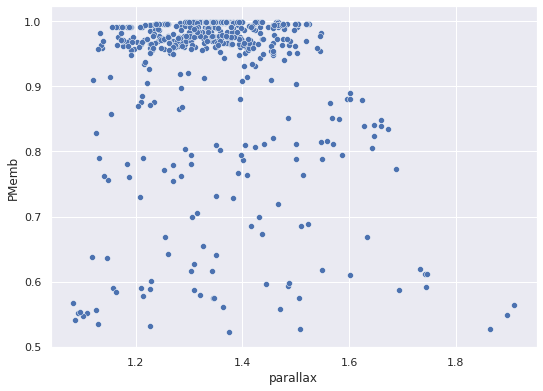

In [164]:
# parallax plot
sns.scatterplot(x = 'parallax', y = 'PMemb',  
                      palette='YlOrRd', data = GAIA_target_stars[GAIA_target_stars['PMemb'] >= 0.5] )

In [165]:
# saving the files as csv
# all_stars.to_csv('gaia_2264_membership_prob.csv')

potentialMember.to_csv('NGC_2264_membership_prob.csv')


### Comparing the old and new predicted members

In [166]:
# creating subset for the potential member in previous dataset

concatenated = pd.concat([potentialMember.assign(dataset='New_member'), member.assign(dataset='Old_member')])


In [167]:
concatenated.describe()

,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,...,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,dist,pmra_over_error,pmdec_over_error,dist_2264_center,member,PMemb
count,6.930000e+02,6.930000e+02,6.930000e+02,693.0,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.0,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,...,685.000000,685.000000,685.000000,693.000000,685.000000,685.000000,685.000000,8.000000,8.000000,693.000000,8.000000,8.000000,8.0,693.000000,693.000000,693.000000,693.000000,505.000000,505.000000,505.000000,505.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,462.0,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,693.000000,693.000000,693.000000,693.000000,693.0,693.000000
mean,1.635721e+18,3.327143e+18,8.370212e+08,2015.5,100.213907,0.075936,9.760619,0.074181,1.350683,0.086528,20.445524,-1.947400,0.147145,-3.720519,0.128364,-0.136840,0.013480,-0.231863,0.263885,-0.358359,0.150040,-0.361183,0.247100,0.099935,-0.110429,142.924964,12.007215,142.119769,0.805195,3.255830,224.325485,0.202259,3.091883,31.0,25.853237,1.393754,0.020005,-0.035326,16.354978,10.445887,...,184.658478,14.737331,1.451967,0.073593,1.969918,0.957252,1.012666,15.942417,6.432655,0.063492,6093.750000,3.875000,0.0,203.042850,2.110055,100.345491,-13.312499,100333.950495,4483.648438,4211.725586,4880.216309,1.746662,1.459142,1.995710,0.879461,0.728607,1.008131,200111.0,1.380871,1.177389,1.521124,1.225030,1.144437,1.305624,0.286402,16.843255,37.222668,0.286411,1.0,0.906409
std,0.000000e+00,3.024363e+15,4.939624e+08,0.0,0.172431,0.036130,0.245852,0.035409,0.118110,0.042251,11.512913,0.540027,0.069364,0.345986,0.060682,0.169157,0.151364,0.155951,0.138072,0.139980,0.152772,0.129107,0.104931,0.104519,0.168859,19.387369,39.746323,19.212271,1.332509,5.444935,235.438461,0.194583,8.278821,0.0,64.878174,0.126318,0.009573,0.089663,2.144584,0.728468,...,205.358521,1.666264,0.206465,0.297501,0.690335,0.405814,0.321878,9.023086,4.261168,0.607285,461.702942,0.517549,0.0,0.238680,0.180069,0.176663,0.244443,745.467832,1340.919678,1205.530518,1366.006958,0.986934,0.934662,1.017196,0.499903,0.471283,0.521020,0.0,0.605764,0.587218,0.606773,6.011191,5.682328,6.340232,0.161214,10.067979,19.909262,0.161218,0.0,0.150512
min,1.635721e+18,3.326589e+18,5.929410e+05,2015.5,99.637923,0.020872,9.304602,0.019971,1.082534,0.021649,5.836907,-4.065149,0.039281,-5.199818,0.035394,-0.960296,-0.685270,-0.885211,-0.634873,-0.876462,-0.676993,-0.933394,-0.694126,-0.667703,-0.896725,86.000000,0.000000,85.000000,0.000000,-6.599565,48.506165,0.000000,0.000000,31.0,0.7257

In [168]:
member.describe()

,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,...,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,dist,pmra_over_error,pmdec_over_error,PMemb,dist_2264_center,member
count,1.790000e+02,1.790000e+02,1.790000e+02,179.0,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.0,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,...,174.000000,174.000000,174.000000,179.000000,174.000000,174.000000,174.000000,3.000000,3.000000,179.000000,3.000000,3.000000,3.0,179.000000,179.000000,179.000000,179.000000,143.000000,143.000000,143.000000,143.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,128.0,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.0
mean,1.635721e+18,3.326785e+18,8.179047e+08,2015.5,100.214606,0.068841,9.878412,0.068337,1.353609,0.078069,22.170341,-1.702357,0.134283,-3.744136,0.119643,-0.128453,-0.011823,-0.234603,0.282137,-0.383949,0.180337,-0.362278,0.203304,0.089937,-0.103888,153.039106,17.597765,152.089385,0.949721,3.743837,259.469513,0.190569,3.486339,31.0,29.216709,1.404429,0.017565,-0.035321,17.430168,10.642458,...,191.386612,14.465166,1.458958,0.134078,1.840550,0.853739,0.986811,17.663946,6.709235,0.106145,5833.333496,3.833333,0.0,202.938330,2.164443,100.337388,-13.195058,100560.524476,4534.251465,4247.730469,4906.962402,1.747458,1.442371,1.986919,0.877488,0.713944,1.003771,200111.0,1.408720,1.217725,1.548704,1.195102,1.119066,1.271138,0.080355,16.101421,39.682193,0.869274,0.080356,1.0
std,0.000000e+00,8.903693e+13,5.036347e+08,0.0,0.060760,0.035174,0.062688,0.035382,0.095768,0.040253,10.771284,0.439287,0.067412,0.295697,0.060553,0.169292,0.138736,0.125775,0.134571,0.128509,0.130683,0.112218,0.113907,0.110772,0.184342,17.305699,48.216334,17.323519,1.503829,6.493741,316.778503,0.198130,9.287979,0.0,73.276215,0.133290,0.008888,0.078954,1.951486,0.675067,...,187.253815,1.783463,0.204588,0.415852,0.679334,0.369787,0.345374,6.235787,4.756371,0.824428,288.675140,0.577350,0.0,0.057346,0.065031,0.060616,0.063483,900.873362,1418.274048,1241.912231,1467.577515,0.987902,0.909715,1.042373,0.494933,0.455351,0.527763,0.0,0.618332,0.618088,0.611171,3.740212,3.529193,3.951503,0.044847,8.739512,18.833557,0.203357,0.044847,0.0
min,1.635721e+18,3.326712e+18,5.929410e+05,2015.5,100.057096,0.023724,9.751314,0.022577,1.111028,0.026016,6.770302,-3.389699,0.045983,-5.199818,0.041781,-0.960296,-0.685270,-0.885211,-0.377267,-0.702543,-0.271878,-0.933394,-0.694126,-0.667703,-0.896725,105.000000,0.000000,101.000000,0.000000,-6.497139,53.549519,0.000000,0.000000,31.0,0.800282,

In [169]:
concatenated.dataset.value_counts()

New_member    514
Old_member    179
Name: dataset, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

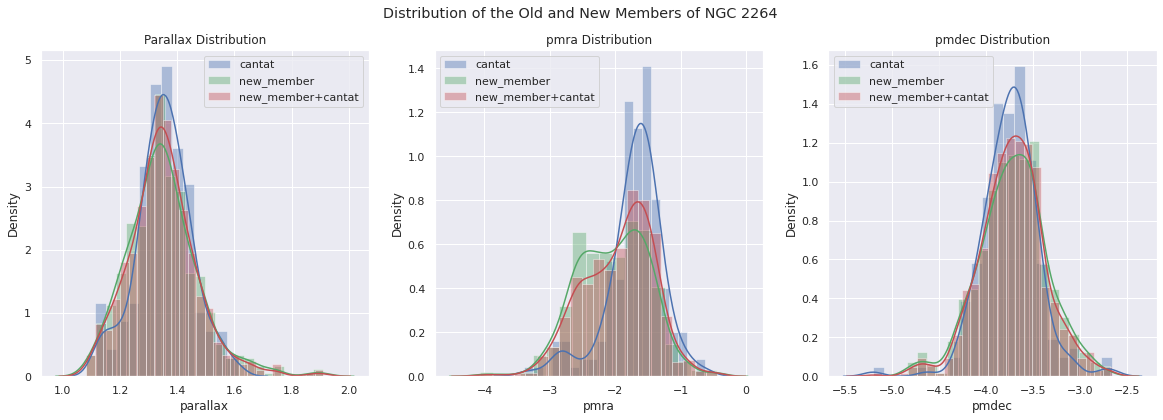

In [170]:
fig, axes = plt.subplots(1, 3, figsize=(20,6))
fig.suptitle('Distribution of the Old and New Members of NGC 2264')


sns.distplot(member['parallax'], color = 'b', label = 'cantat', 
             kde=True, ax=axes[0])
sns.distplot(potentialMember['parallax'], color = 'g', label = 'new_member', 
             kde=True, ax=axes[0])
sns.distplot(concatenated['parallax'], color = 'r', ax=axes[0], kde=True,
             label = 'new_member+cantat')
axes[0].set_title('Parallax Distribution')
axes[0].legend()

sns.distplot(member['pmra'], color = 'b', label = 'cantat', 
             kde=True, ax=axes[1])
sns.distplot(potentialMember['pmra'], color = 'g', label = 'new_member', 
             kde=True, ax=axes[1])
sns.distplot(concatenated['pmra'], color = 'r', ax=axes[1], kde=True,
             label = 'new_member+cantat')
axes[1].set_title('pmra Distribution')
axes[1].legend()

sns.distplot(member['pmdec'], color = 'b', label = 'cantat', 
             kde=True, ax=axes[2])
sns.distplot(potentialMember['pmdec'], color = 'g', label = 'new_member', 
             kde=True, ax=axes[2])
sns.distplot(concatenated['pmdec'], color = 'r', ax=axes[2], kde=True,
             label = 'new_member+cantat')
axes[2].set_title('pmdec Distribution')
axes[2].legend()

plt.show()


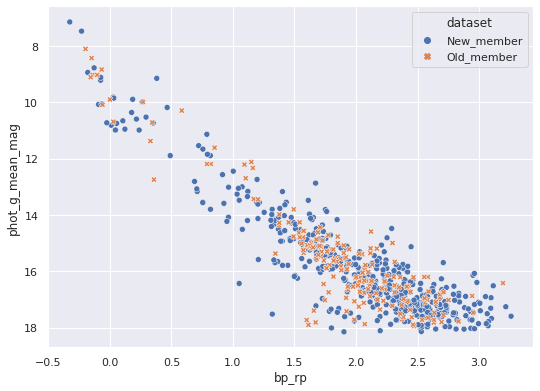

In [171]:
cmd = sns.scatterplot(x='bp_rp', y='phot_g_mean_mag', data=concatenated,
                hue='dataset', style = 'dataset')
cmd.invert_yaxis()

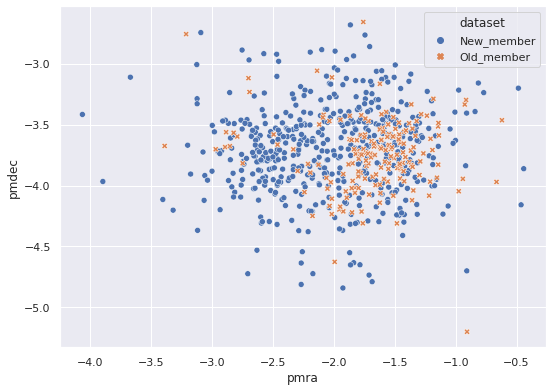

In [172]:
sns.scatterplot(x='pmra', y='pmdec', data=concatenated,
                hue='dataset', style = 'dataset')

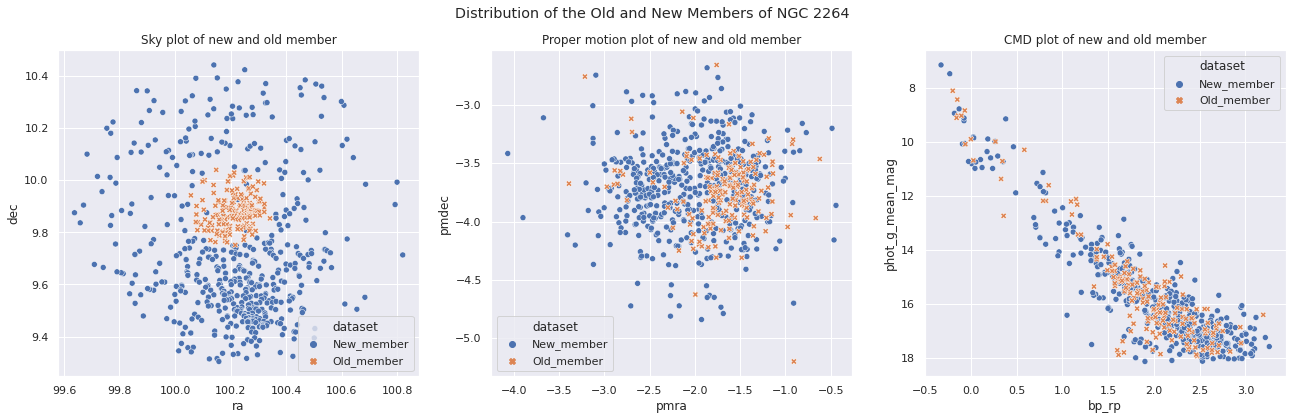

In [173]:
fig, axes = plt.subplots(1, 3, figsize=(22,6))
fig.suptitle('Distribution of the Old and New Members of NGC 2264')

skyplot = sns.scatterplot(x='ra', y='dec', data=concatenated,
                hue='dataset',  style = 'dataset', ax=axes[0])
axes[0].set_title('Sky plot of new and old member')

# proper motion plot
sns.scatterplot(x='pmra', y='pmdec', data=concatenated,
                hue='dataset', ax=axes[1], style = 'dataset')
axes[1].set_title('Proper motion plot of new and old member')

cmd = sns.scatterplot(x='bp_rp', y='phot_g_mean_mag', data=concatenated,
                hue='dataset', ax = axes[2], style = 'dataset')
cmd.invert_yaxis()
axes[2].set_title('CMD plot of new and old member')


plt.show()

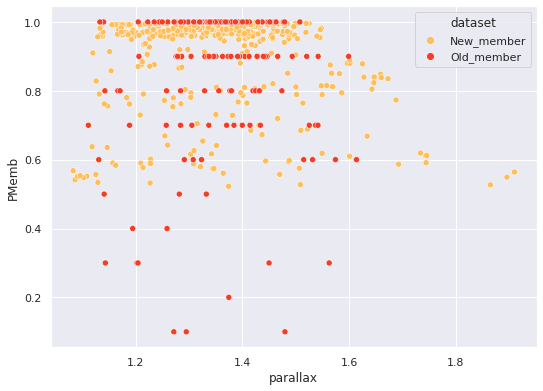

In [174]:
# parallax vs PMemb plot
sns.scatterplot(x = 'parallax', y = 'PMemb',  hue = 'dataset',
                      palette='YlOrRd', data = concatenated )

In [175]:
# pd_prof.ProfileReport(potentialMember)

In [176]:
#files.download('NGC_2264_cantat.csv')

#files.download('NGC_2264_membership_prob.csv')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


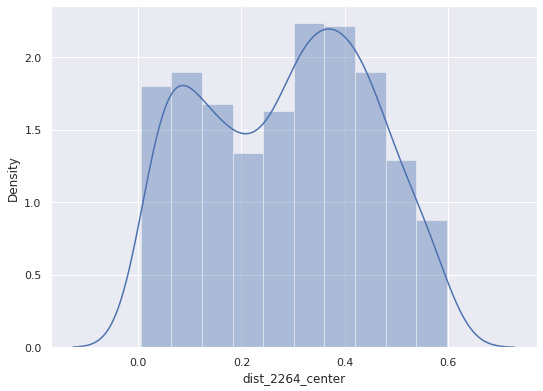

In [177]:
sns.distplot(concatenated['dist_2264_center'])

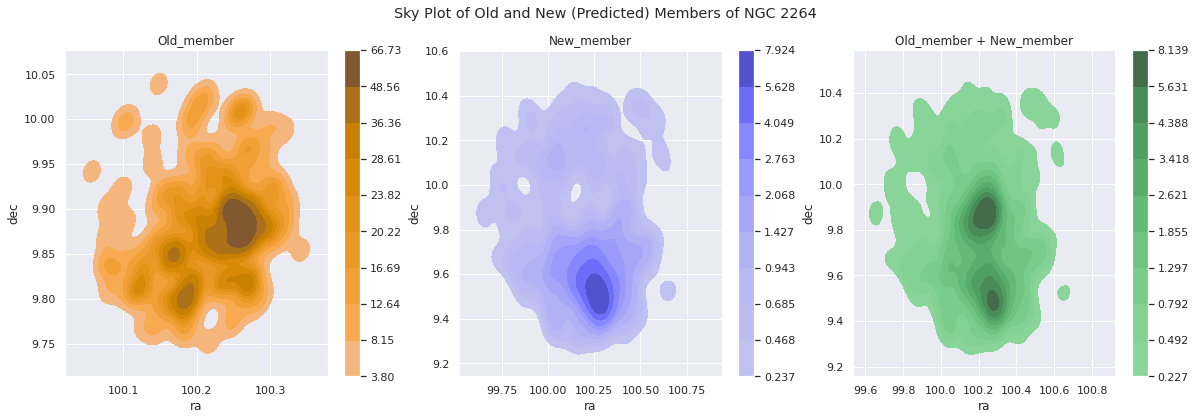

In [178]:

fig, axes = plt.subplots(1, 3, figsize=(20,6))
fig.suptitle('Sky Plot of Old and New (Predicted) Members of NGC 2264')

sns.kdeplot(x='ra', y='dec', data = member, shade=True, color = 'orange', 
            bw_method = 0.20, cbar=True, ax=axes[0])
axes[0].set_title('Old_member')

sns.kdeplot(x='ra', y='dec', data = potentialMember, shade=True, color = 'blue', 
            bw_method = 0.20, cbar=True, ax=axes[1])
axes[1].set_title('New_member')

sns.kdeplot(x='ra', y='dec', data = concatenated, shade=True, color = 'g', 
            bw_method = 0.20, cbar=True, ax=axes[2])
axes[2].set_title('Old_member + New_member')

plt.show()

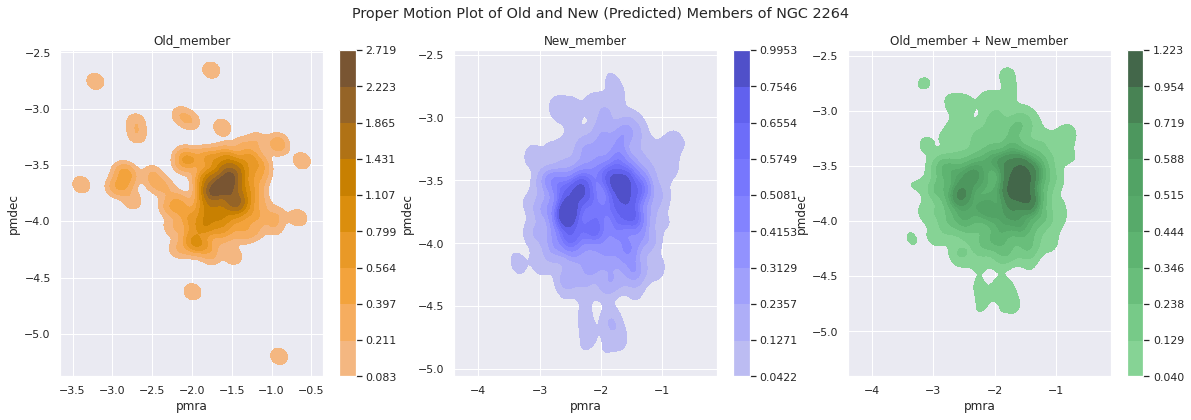

In [179]:

fig, axes = plt.subplots(1, 3, figsize=(20,6))
fig.suptitle('Proper Motion Plot of Old and New (Predicted) Members of NGC 2264')

sns.kdeplot(x='pmra', y='pmdec', data = member, shade=True, color = 'orange', 
            bw_method = 0.20, cbar=True, ax=axes[0])
axes[0].set_title('Old_member')

sns.kdeplot(x='pmra', y='pmdec', data = potentialMember, shade=True, color = 'blue', 
            bw_method = 0.20, cbar=True, ax=axes[1])
axes[1].set_title('New_member')

sns.kdeplot(x='pmra', y='pmdec', data = concatenated, shade=True, color = 'g', 
            bw_method = 0.20, cbar=True, ax=axes[2])
axes[2].set_title('Old_member + New_member')

plt.show()

In [180]:
#files.download('NGC_2264_cantat.csv')

potentialMember.to_csv('NGC_2264_additional_member_prob.csv')
concatenated.to_csv('NGC_2264_all_member_prob.csv')

files.download('NGC_2264_all_member_prob.csv')
# column 'dataset': Old_member, New_member
# column 'member': 0 and 1
# column 'PMemb': decimal values between 0 to 1

files.download('NGC_2264_additional_member_prob.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>